## Step 1: Importing Essential Libraries<a id='step-1'></a>

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_curve,auc,classification_report
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random
import os
#print(os.listdir("../input"))


In [10]:
pwd

'C:\\Users\\Hannah\\Desktop\\DL_projecT'

## Step 2: Loading Data<a id='step-2'></a>
In this step we will first create separate directory to store Parasitized and Normal images (Uninfected)

In [19]:
# setting path of directory
PARA_DIR = r"C:\Users\Hannah\Desktop\DL_projecT\cell_images\cell_images\Parasitized"
NORM_DIR =  r"C:\Users\Hannah\Desktop\DL_projecT\cell_images\cell_images\Uninfected"

# storing all the files from directories PARA_DIR and NORM_DIR to Pimages and Nimages for accessing images directly
Pimages = os.listdir(PARA_DIR)
Nimages = os.listdir(NORM_DIR)

## Step 3: EDA -> Checking sample images<a id='step-3'></a>
In this step we will check the actual sample images of both infected and normal blood sample

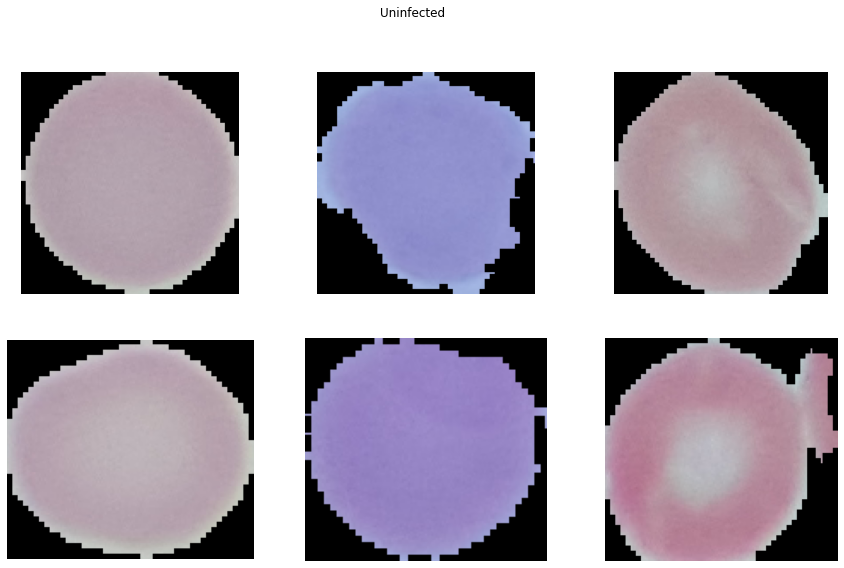

In [20]:
sample_normal = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('cell_images/Uninfected/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Uninfected')
plt.show()


**Observation:**
- As we can see from above images that in infected sample there is small dot in almost every image which may be the critical mark while recognizing the imfected image. the model has to learn this pattern during training stage.
- As we can see normal images are clear with no mark to show.

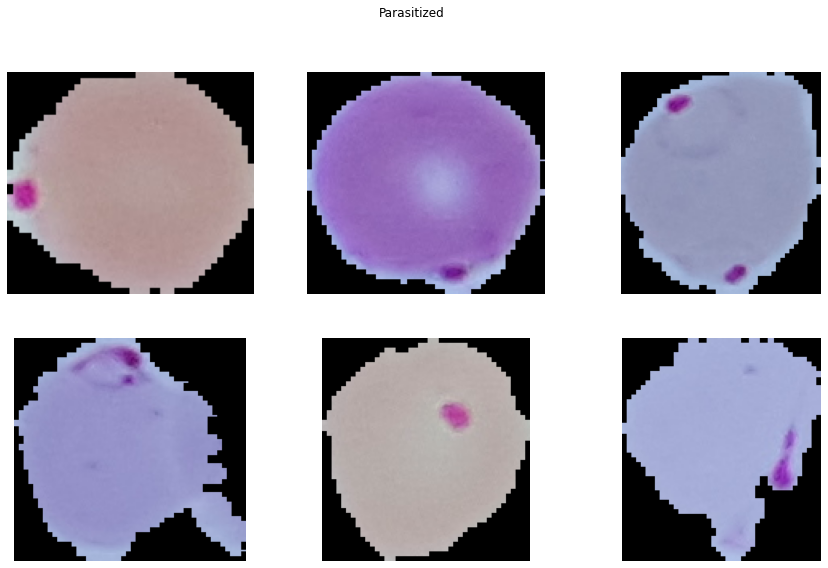

In [4]:
sample_parasite = random.sample(Pimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('cell_images/Parasitized/'+sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Parasitized')
plt.show()

## Step 4: Data Preprocessing (Labeling & Resizing of images)<a id='step-4'></a>

In [5]:
data=[]
labels=[]
Parasitized=os.listdir("cell_images/Parasitized/")
for a in Parasitized:
    try:
        image=cv2.imread("cell_images/Parasitized/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Uninfected=os.listdir("cell_images/Uninfected/")
for b in Uninfected:
    try:
        image=cv2.imread("cell_images/Uninfected/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

In [6]:
# segregating data and labels
Cells=np.array(data)
labels=np.array(labels)

np.save("Cells",Cells)
np.save("labels",labels)

In [7]:
# loading data of cell images and labels of images
Cells=np.load("Cells.npy")
labels=np.load("labels.npy")

In [8]:
labels.shape,Cells.shape

((27558,), (27558, 50, 50, 3))

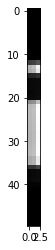

In [9]:
import numpy as np
arr=np.load('Cells.npy')
from matplotlib import pyplot as plt
plt.imshow(arr[0][3],cmap='gray')
plt.show()

In [10]:
s=np.arange(Cells.shape[0])
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

num_classes=len(np.unique(labels))
len_data=len(Cells)

In [11]:
0.1*len_data

2755.8

## Step 5: Train- Test Split<a id='step-5'></a>

In [12]:
# splitting cells images into 90:10 ratio i.e., 90% for training and 10% for testing purpose
(x_train,x_test)=Cells[(int)(0.1*len_data):],Cells[:(int)(0.1*len_data)]

(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

## Step 6: Normalizing Data<a id='step-6'></a>

In [13]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [14]:
train_len,test_len

(24803, 2755)

## Step 7: Label Encoding<a id='step-7'></a>

In [15]:
#Doing One hot encoding as classifier has multiple classes
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [16]:
y_train[112]

array([0., 1.], dtype=float32)

In [17]:
from keras.layers import AveragePooling2D

## Step 8: Model Building: CNN<a id='step-8'></a>

In [18]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=3,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=32,kernel_size=4,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128,kernel_size=4,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))

model.add(Dense(2,activation="sigmoid"))   #2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        1

## Step 9: Compiling the model<a id='step-9'></a>

In [19]:
# compile the model with loss as categorical_crossentropy and using adam optimizer you can test result by trying RMSProp as well as Momentum
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Step 10: Setting Callbacks<a id='step-10'></a>

In [20]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

## Step 11: Model Fitting<a id='step-11'></a>

In [21]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
h=model.fit(x_train,y_train,batch_size=32,callbacks=callbacks, validation_data=(x_test,y_test),epochs=10,verbose=1)

Epoch 1/10
776/776 [==============================] - 79s 101ms/step - loss: 0.6933 - accuracy: 0.5085 - val_loss: 0.6912 - val_accuracy: 0.5013
Epoch 2/10
776/776 [==============================] - 76s 98ms/step - loss: 0.6903 - accuracy: 0.5264 - val_loss: 0.6534 - val_accuracy: 0.6094
Epoch 3/10
776/776 [==============================] - 74s 95ms/step - loss: 0.2394 - accuracy: 0.9103 - val_loss: 0.1493 - val_accuracy: 0.9543
Epoch 4/10
776/776 [==============================] - 73s 94ms/step - loss: 0.1554 - accuracy: 0.9524 - val_loss: 0.1334 - val_accuracy: 0.9572cy: 0.95
Epoch 5/10
776/776 [==============================] - 77s 99ms/step - loss: 0.1438 - accuracy: 0.9548 - val_loss: 0.1423 - val_accuracy: 0.9583
Epoch 6/10
776/776 [==============================] - 77s 100ms/step - loss: 0.1373 - accuracy: 0.9556 - val_loss: 0.1265 - val_accuracy: 0.9608
Epoch 7/10
776/776 [==============================] - 77s 99ms/step - loss: 0.1317 - accuracy: 0.9573 - val_loss: 0.1289 - val

## Step 12: Model Evaluation<a id='step-12'></a>

In [22]:
# saving the weight of model
from numpy import loadtxt
from keras.models import load_model
model = load_model('.mdl_wts.hdf5')

#checking the score of the model
score=model.evaluate(x_test,y_test)
print(score)

87/87 [==============================] - 2s 26ms/step - loss: 0.1198 - accuracy: 0.9604 0s - loss: 0.1116 - ac
[0.11975704878568649, 0.9604355692863464]


In [23]:
# checking the accuracy of thr 
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

87/87 [==============================] - 2s 28ms/step - loss: 0.1198 - accuracy: 0.9604 0s - l

 Test_Accuracy:- 0.9604355692863464


### Confusion Matrix

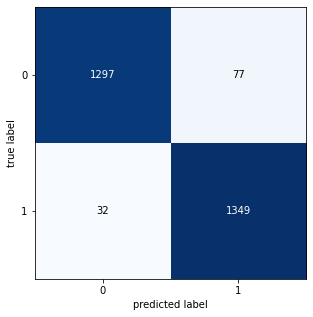

In [24]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

#creating confusion matrix
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
# plotting confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,figsize=(5, 5))
plt.show()

### Plotting History of Model's Accuracy 

In [25]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

<ipython-input-25-21a1cb06bcb9>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
<ipython-input-25-21a1cb06bcb9>:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


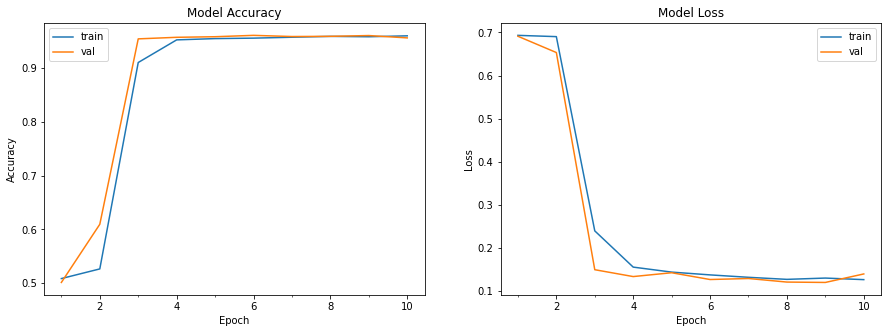

In [26]:
plot_model_history(h)

### Printing Classification report

In [27]:
print('{}'.format( 
                           classification_report(y_true , pred)))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1374
           1       0.95      0.98      0.96      1381

    accuracy                           0.96      2755
   macro avg       0.96      0.96      0.96      2755
weighted avg       0.96      0.96      0.96      2755



## Step 13: Plotting ROC AUC Curve<a id='step-13'></a>
In this step we will first compute Are Under Curve (AUC) based on which we plot ROC curve

### Computing Area Under Curve (AUC)

In [28]:
fpr_keras, tpr_keras, thresholds = roc_curve(y_true.ravel(), pred.ravel())
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.960393814156988

In [29]:
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

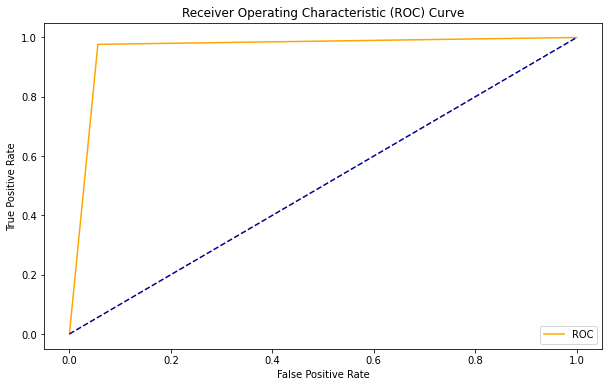

In [30]:
plot_roc_curve(fpr_keras, tpr_keras)

## Step 14: Plotting Sample Prediction (Groundtruth vs Predicted)<a id='step-14'></a>
In this step we will test our model by plotting 12 random prediction in which ground truth is in brackets and predicted value is outside the bracket if both match then the color will be blue whereas incorrect or misclassified instances will show in orange color.

In [31]:
y_hat = model.predict(x_test)

# define text labels 
malaria_labels = ['Parasitized','Uninfected']

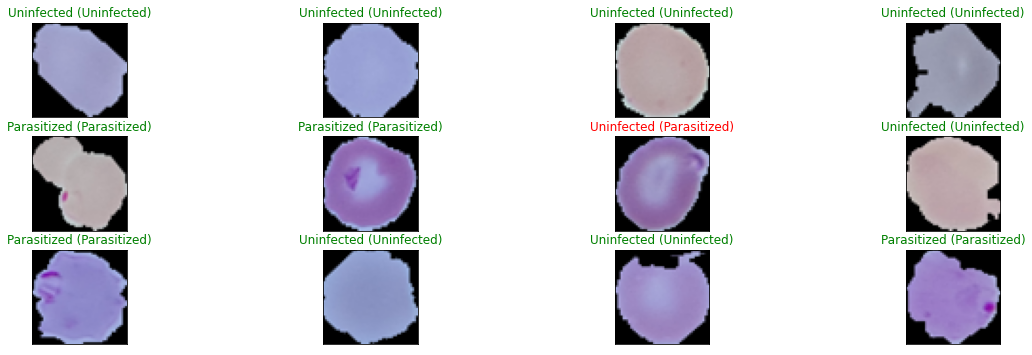

In [41]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(malaria_labels[pred_idx], malaria_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

## Conclusion

- Model is giving approx 96% recall and auc of around 96.36 which is good overall.
